# Analysis for Column

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sympy import *
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["font.weight"] = "normal"
plt.rcParams.update({'figure.max_open_warning': 0})

In [99]:
class Column():
    
    def __init__(self, **kwargs):
        # Parse Input Parameters
        for key, value in kwargs.items():
            if key == "k":
                self.k = value
            elif key == "delta0":
                self.delta0 = value
            elif key == "beta":
                self.beta = value
            elif key == "T0":
                self.T0 = value
            elif key == "T1":
                self.T1 = value
            elif key == "delta_T1":
                self.delta_T1 = value
            elif key == "theta":
                self.theta = value
            elif key == "R0": 
                self.R0 = value
            elif key == "T":
                self.T = value
            elif key == "R_T":
                self.R_T = value
            elif key == "phi":
                self.phi = value
            elif key == "D":
                self.D = value
            elif key == "mean_deadLoad":
                self.mean_deadLoad = value
            elif key == "variance_deadLoad":
                self.variance_deadLoad = value
            elif key == "mean_sustainedLoad":
                self.mean_sustainedLoad = value
            elif key == "variance_sustaineLoad":
                self.variance_sustaineLoad = value
            elif key == "beta_sustaintedLoad":
                self.beta_sustaintedLoad = value
            elif key == "mean_extroLoad":
                self.mean_extroLoad = value
            elif key == "variance_extroLoad":
                self.variance_extroLoad = value
            elif key == "beta_extroLoad":
                self.beta_extroLoad = value
            elif key == "load_duration":
                self.load_duration = value
            elif key == "L_t":
                self.L_t = value
            elif key == "B_t":
                self.B_t = value
            elif key == "alphaA":
                self.alphaA = value
            elif key == "alphaB":
                self.alphaB = value
        
        self.delta_T0 = self.k * self.delta0
        
    """
        PART 1 - Crack Depth (mm)
    """
    def calculateLambda(self):
        lam = ( (self.delta_T1 - self.delta_T0) * self.T0 ) / ( self.k * self.delta0 * (self.T1 - self.T0)**self.beta )
        self.lam = lam
        return lam
    
    def calculateDeltaT_year(self, duration_year=1000):
        deltaT = []
        duration_year = int(duration_year)
        if duration_year < self.T0:
            for year in range(duration_year):
                deltaT.append( self.k * self.delta0 * year / self.T0 )
                
        else:
            for year in range(duration_year):
                if year <= self.T0:
                    deltaT.append( self.k * self.delta0 * year / self.T0 )
                else:
                    deltaT.append( self.k * self.delta0 * (1 + self.lam * (year - self.T0)**self.beta / self.T0) )
            
        return deltaT
    
        
    def calculateDeltaT_day(self, duration_year=1000):
        deltaT_day = []
        deltaT_year = self.calculateDeltaT_year(duration_year)
        for delta in deltaT_year:
            deltaT_day += [delta] * 365
        return deltaT_day
    
    """
        PART 2 - Strength Degradation (Mpa)
    """
    def calculateA(self):
        a = ( 1 - self.R_T / self.R0 ) / ( self.T ** self.theta )
        self.a = a
        return a
    
    def calculateR_year(self, duration_year=1000):
        R_year = []
        for year in range(duration_year):
            R_year.append( self.R0 * (1 - self.a * year ** self.theta) )
        return R_year
    
    def calculateR_day(self, duration_year=1000):
        R_day = []
        R_year = self.calculateR_year(duration_year)
        for R in R_year:
            R_day += [R] * 365
        return R_day
    
    """
        PART 3 - Sigma S (Mpa)
    """
    def calculateSigmaS_year(self, duration_year=1000):
        sigmaS_year = []
        deltaT_year = self.calculateDeltaT_year(duration_year)
        R_year = self.calculateR_year(duration_year)
        for index in range(duration_year):
            a_eff = math.pi * (self.D - 2 * deltaT_year[index]/1000) ** 2 / 4
            sigmaS_year.append(self.phi * R_year[index] * a_eff)
        return sigmaS_year
    
    def calculateSigmaS_day(self, duration_year=1000):
        sigmaS_day = []
        deltaT_day = self.calculateDeltaT_day(duration_year)
        R_day = self.calculateR_day(duration_year)
        for index in range(len(deltaT_day)):
            a_eff = math.pi * (self.D - 2 * deltaT_day[index]/1000) ** 2 / 4
            sigmaS_day.append(self.phi * R_day[index] * a_eff)
        return sigmaS_day
    
    """
        PART 4 - Simulate Loads (kPa)
    """
    def calculateDeadLoadSingle(self):
        mu = self.mean_deadLoad
        sigma = math.sqrt(self.variance_deadLoad)
        deadLoadSingle = np.random.normal(mu, sigma, 1)[0]
        return deadLoadSingle
        
    def calculateSustainedLiveLoad_day(self, duration_year=1000):
        theta = self.variance_sustaineLoad / self.mean_sustainedLoad
        k = self.mean_sustainedLoad / theta
        timeLimit = 365 * duration_year
        currentTime = 0
        value = []
        sustainedTime = []
        sustainedLiveLoad_day = []
        while currentTime < timeLimit:
            value.append(np.random.gamma(k, theta, 1)[0])
            duration = int(np.random.exponential(self.beta_sustaintedLoad, 1)[0] * 365)
            sustainedTime.append(duration)
            currentTime += duration
        for index in range(len(sustainedTime)):
            sustainedLiveLoad_day += [value[index]] * sustainedTime[index]
        return sustainedLiveLoad_day[:duration_year*365]
    
    def calculateSustainedLiveLoad_year(self, duration_year=1000):
        sustainedLiveLoad_day = self.calculateSustainedLiveLoad_day(duration_year)
        sustainedLiveLoad_year = []
        for year in range(duration_year):
            sustainedLiveLoad_year.append(np.mean(sustainedLiveLoad_day[year*365: (year+1)*365]))
        return sustainedLiveLoad_year
    
    def calculateExtroLoad_day(self, duration_year=1000):
        theta = self.variance_extroLoad / self.mean_extroLoad
        k = self.mean_extroLoad / theta
        extroLiveLoad_day = [0] * 365 * 1000
        for i in range(duration_year):
            extroLive = np.random.gamma(k, theta, 1)[0]
            duration = random.randint(1, self.load_duration)
            occurance = int(np.random.exponential(self.beta_extroLoad, 1)[0])
            time = (np.random.random(occurance) * 365).astype(int)
            for startTime in time:
                for j in range(startTime, startTime + duration):
                    extroLiveLoad_day[i*365 + j] += extroLive
        extroLiveLoad_day = extroLiveLoad_day[:365 * duration_year]
        return extroLiveLoad_day
    
    def calculateExtroLoad_year(self, duration_year=1000):
        extroLiveLoad_day = self.calculateExtroLoad_day(duration_year)
        extroLiveLoad_year = []
        for year in range(duration_year):
            extroLiveLoad_year.append(np.mean(extroLiveLoad_day[year*365: (year+1)*365]))
        return extroLiveLoad_year
    
    """
        PART 5 - Sigma T (Mpa)
    """
    def calculateSigmaT_day(self, duration_year=1000):
        deadLoadSingle = self.calculateDeadLoadSingle()
        sustainedLive_day = self.calculateSustainedLiveLoad_day(duration_year)
        w = np.array(sustainedLive_day) + deadLoadSingle
        sigmaT_day = w * self.B_t * self.L_t / 1000
        return sigmaT_day
    
    def calculateSigmaT_year(self, duration_year=1000):
        deadLoadSingle = self.calculateDeadLoadSingle()
        sustainedLive_year = self.calculateSustainedLiveLoad_year(duration_year)
        w = np.array(sustainedLive_year) + deadLoadSingle
        sigmaT_year = w * self.B_t * self.L_t / 1000
        return sigmaT_year
    
    def calculateSigmaT(self, deadLoadSingle, sustainedLive):
        w = (np.array(sustainedLive) + deadLoadSingle) / 1000
        sigmaT = w * self.B_t * self.L_t
        return sigmaT
    
    """
        PART 6 - Damage Accumulation Alpha
    """
    def calculateAlpha(self, sigmaT, sigmaS):
        a = self.alphaA * np.log(10) / self.alphaB
        b = np.log(10) / self.alphaB
        alphaRate = []
        Alpha = []
        if len(list(sigmaT)) == len(list(sigmaS)):
            sigmaT = list(sigmaT)
            sigmaS = list(sigmaS)
            for index in range(len(list(sigmaT))):
                alphaRate.append( np.exp(-a + b * sigmaT[index] / sigmaS[index]) )
            
            Alpha = np.cumsum(alphaRate)
            return alphaRate, Alpha
        else:
            print("LENGTH OF SIGMAT AND SIGMAS SHOULD BE THE SAME!")
        return alphaRate, Alpha
    

In [100]:
# INPUT PARAMETERS
params_column = {
    "k" : 0.5,               # ========= DeltaT
    "delta0" : 2*2.34, 
    "beta": 2, 
    "T0" : 267, 
    "T1": 954, 
    "delta_T1": 114.7,          
    "theta": 2,             # ========= Degradation
    "R0": 56.49, 
    "T": 921, 
    "R_T": 45.87,           
    "phi": 0.75,             # ========= SigmaS
    "D": 0.38, 
    "mean_deadLoad": 1.63,            # ========= Loads
    "variance_deadLoad": 0.1,
    "mean_sustainedLoad": 0.6, 
    "variance_sustaineLoad": 0.13, 
    "beta_sustaintedLoad": 10, 
    "mean_extroLoad": 0.5,
    "variance_extroLoad": 0.7478, 
    "beta_extroLoad": 10/3, 
    "load_duration": 5,
    "B_t": 2.26,                        # ======== Sigma T
    "L_t": 5.385,
    "alphaA": 0.9,                      # ======== Alpha
    "alphaB": 0.0495
}

In [101]:
# Crack Depth
circular_column = Column(**params_column)
lam = circular_column.calculateLambda()
deltaT_year = circular_column.calculateDeltaT_year(duration_year=1000)
deltaT_day = circular_column.calculateDeltaT_day(duration_year=1000)

# Strength Degradation
a = circular_column.calculateA()
R_year = circular_column.calculateR_year(duration_year=1000)
R_day = circular_column.calculateR_day(duration_year=1000)

# Sigma S
sigmaS_year = circular_column.calculateSigmaS_year(duration_year=1000)
sigmaS_day = circular_column.calculateSigmaS_day(duration_year=1000)

# Load
deadLoadSingle = circular_column.calculateDeadLoadSingle()
sustainedLiveLoad_day = circular_column.calculateSustainedLiveLoad_day(duration_year=1000)
sustainedLiveLoad_year = circular_column.calculateSustainedLiveLoad_year(duration_year=1000)
extroLiveLoad_day = circular_column.calculateExtroLoad_day(duration_year=1000)

# Sigma T
sigmaT_day = circular_column.calculateSigmaT_day(duration_year=1000)
sigmaT_year = circular_column.calculateSigmaT_year(duration_year=1000)

# AlphaRate and Alpha
alphaRate, Alpha = circular_column.calculateAlpha(sigmaT=sigmaT_day, sigmaS=sigmaS_day)

# Figure Plotting

## 1 - Crack Depth

Text(0, 0.5, '')

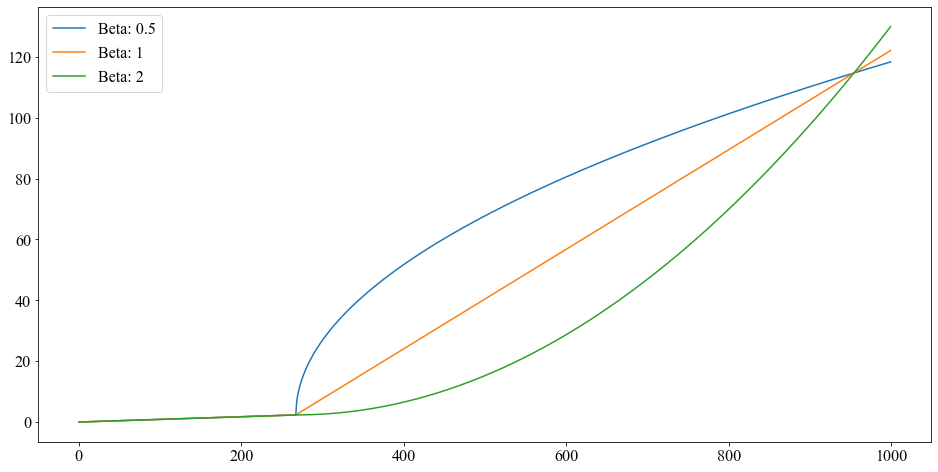

In [102]:
betaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    params_column["beta"] = beta
    circular_column = Column(**params_column)
    lam = circular_column.calculateLambda()
    deltaT_year = circular_column.calculateDeltaT_year(duration_year=1000)
    label = "Beta: " + str(beta)
    plt.plot(deltaT_year, label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 2 - Strength Degradation

Text(0, 0.5, '')

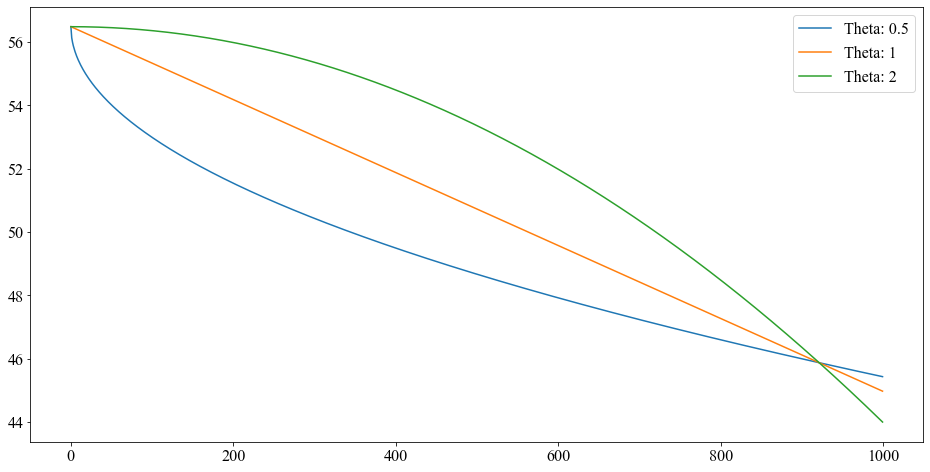

In [103]:
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for theta in thetaList:
    params_column["theta"] = theta
    circular_column = Column(**params_column)
    a = circular_column.calculateA()
    R_year = circular_column.calculateR_year(duration_year=1000)
    label = "Theta: " + str(theta)
    plt.plot(R_year, label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 3 - Sigma T & Sustained + Dead Load

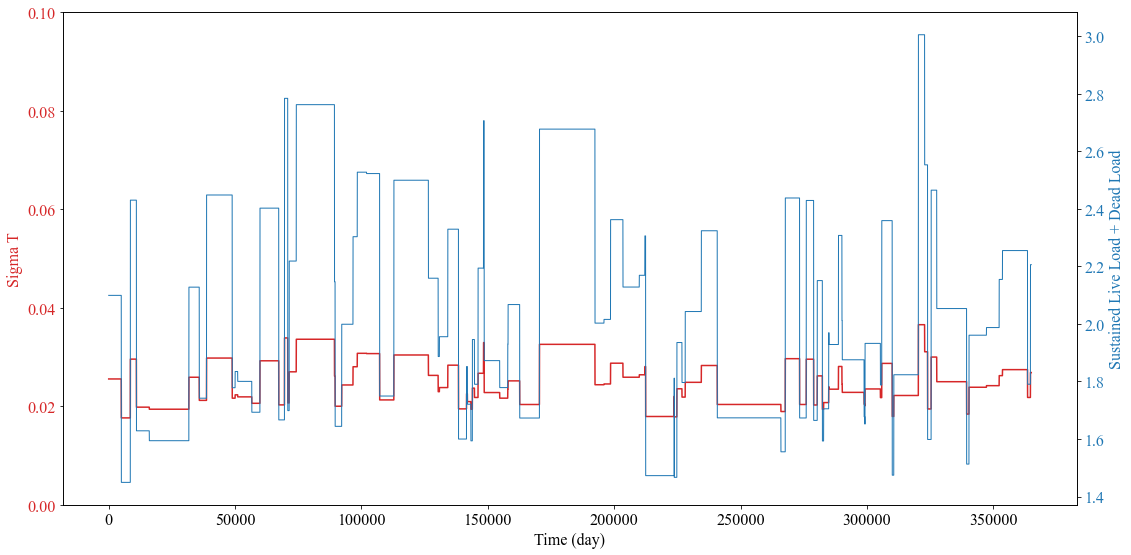

In [119]:
circular_column = Column(**params_column)
deadLoadSingle = circular_column.calculateDeadLoadSingle()
sustainedLiveLoad_day = circular_column.calculateSustainedLiveLoad_day(duration_year=1000)
sigmaT_day = circular_column.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_day)

fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:red'
ax1.set_xlabel('Time (day)')
ax1.set_ylabel('Sigma T', color=color)
ax1.plot(sigmaT_day, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 0.1)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sustained Live Load + Dead Load', color=color)
ax2.plot(sustainedLiveLoad_day + deadLoadSingle, linewidth=1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Text(0, 0.5, '')

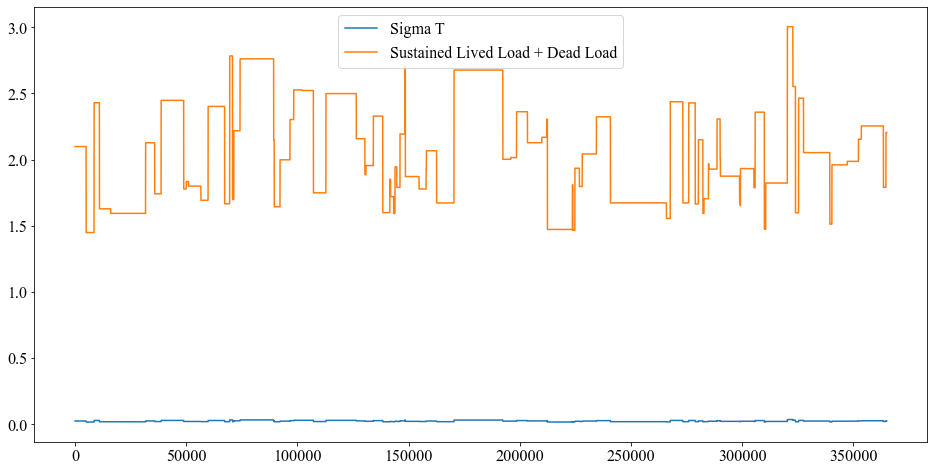

In [120]:
fig = plt.figure(figsize=(16, 8))
plt.plot(sigmaT_day, label="Sigma T")
plt.plot(sustainedLiveLoad_day+deadLoadSingle, label="Sustained Lived Load + Dead Load")
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 4 - Sustained + Dead + Extrodinary Load

Text(0, 0.5, '')

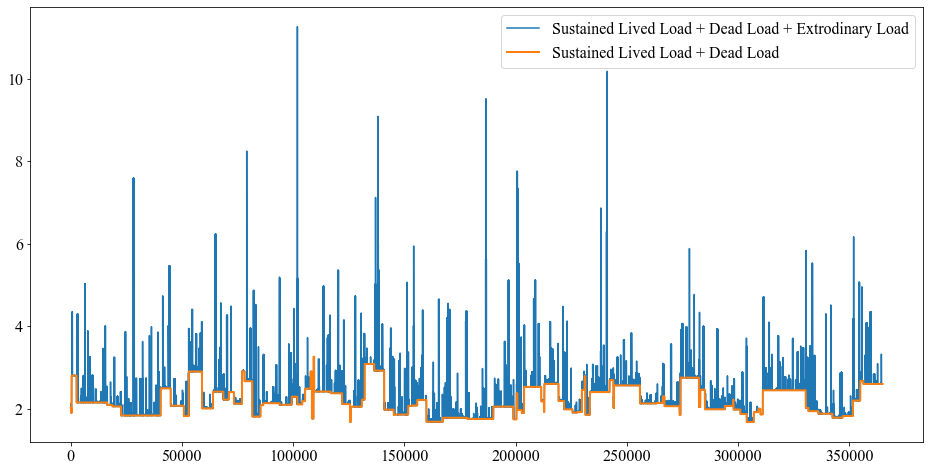

In [122]:
circular_column = Column(**params_column)
deadLoadSingle = circular_column.calculateDeadLoadSingle()
sustainedLiveLoad_day = circular_column.calculateSustainedLiveLoad_day(duration_year=1000)
extroLiveLoad_day = circular_column.calculateExtroLoad_day(duration_year=1000)

fig = plt.figure(figsize=(16, 8))
plt.plot(deadLoadSingle+sustainedLiveLoad_day+extroLiveLoad_day, label="Sustained Lived Load + Dead Load + Extrodinary Load")
plt.plot(deadLoadSingle+sustainedLiveLoad_day, linewidth=2, label="Sustained Lived Load + Dead Load")
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 5 - Sigma S

Text(0, 0.5, '')

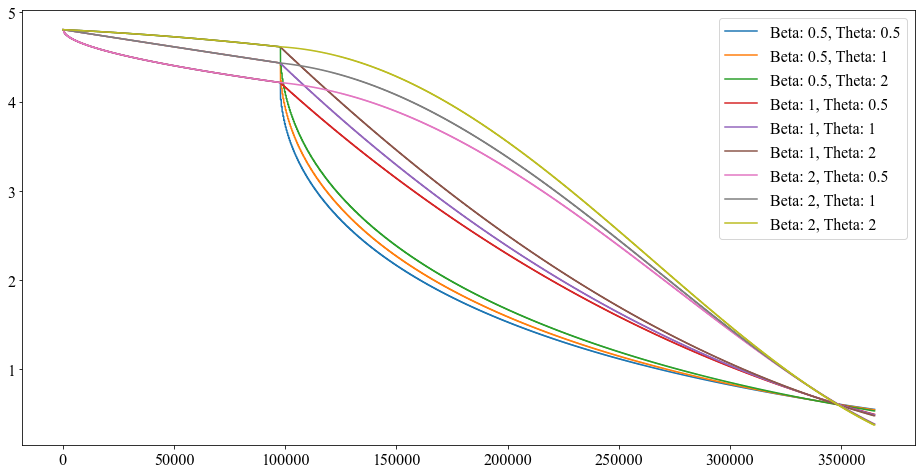

In [124]:
betaList = [0.5, 1, 2]
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    for theta in thetaList:
        params_column["beta"] = beta
        params_column["theta"] = theta
        circular_column = Column(**params_column)
        # Crack Depth
        lam = circular_column.calculateLambda()
        deltaT_day = circular_column.calculateDeltaT_day(duration_year=1000)
        # Strength Degradation
        a = circular_column.calculateA()
        R_day = circular_column.calculateR_day(duration_year=1000)
        sigmaS_day = circular_column.calculateSigmaS_day(duration_year=1000)
        label = "Beta: " + str(beta) + ", Theta: " + str(theta)
        plt.plot(sigmaS_day, label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

Text(0, 0.5, '')

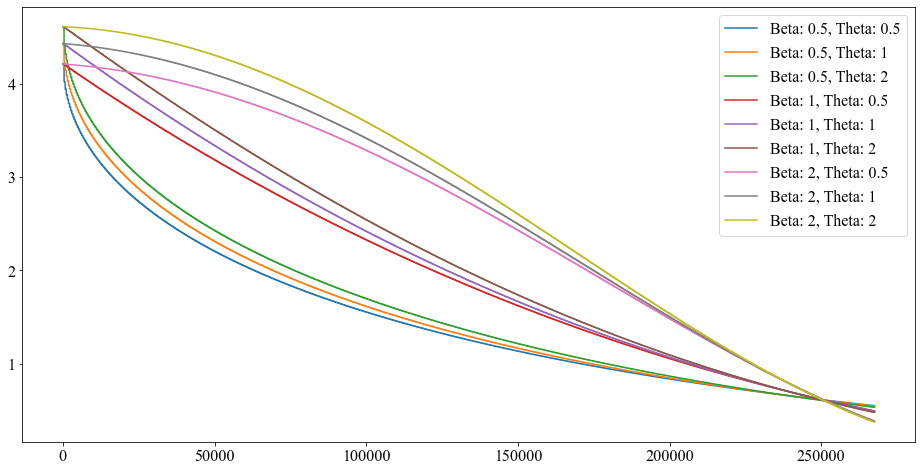

In [125]:
betaList = [0.5, 1, 2]
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    for theta in thetaList:
        params_column["beta"] = beta
        params_column["theta"] = theta
        circular_column = Column(**params_column)
        # Crack Depth
        lam = circular_column.calculateLambda()
        deltaT_day = circular_column.calculateDeltaT_day(duration_year=1000)
        # Strength Degradation
        a = circular_column.calculateA()
        R_day = circular_column.calculateR_day(duration_year=1000)
        sigmaS_day = circular_column.calculateSigmaS_day(duration_year=1000)
        label = "Beta: " + str(beta) + ", Theta: " + str(theta)
        plt.plot(sigmaS_day[267*365:], label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

Text(0, 0.5, '')

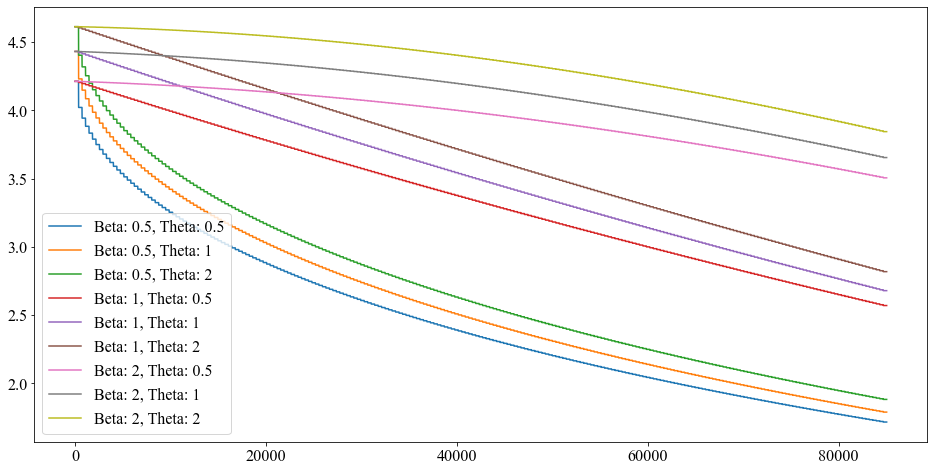

In [126]:
betaList = [0.5, 1, 2]
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    for theta in thetaList:
        params_column["beta"] = beta
        params_column["theta"] = theta
        circular_column = Column(**params_column)
        # Crack Depth
        lam = circular_column.calculateLambda()
        deltaT_day = circular_column.calculateDeltaT_day(duration_year=1000)
        # Strength Degradation
        a = circular_column.calculateA()
        R_day = circular_column.calculateR_day(duration_year=1000)
        sigmaS_day = circular_column.calculateSigmaS_day(duration_year=1000)
        label = "Beta: " + str(beta) + ", Theta: " + str(theta)
        plt.plot(sigmaS_day[267*365:500*365], label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 6 - Extrodinary Load

Text(0, 0.5, '')

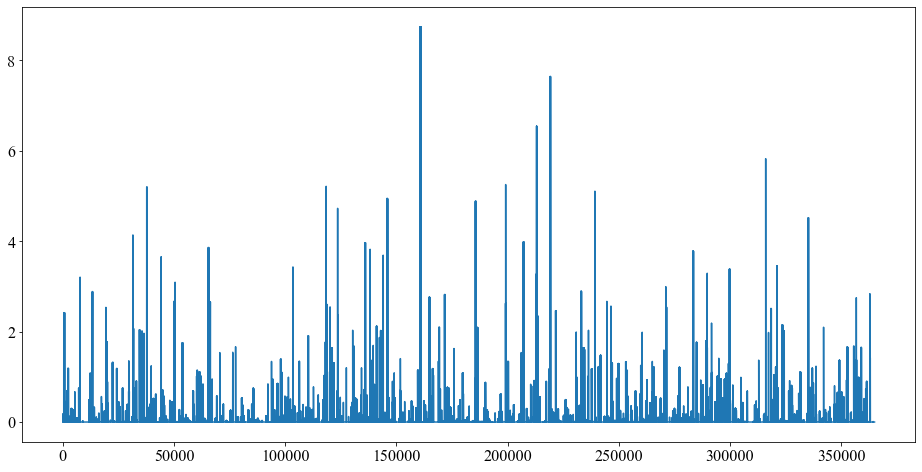

In [127]:
circular_column = Column(**params_column)
extroLiveLoad_day = circular_column.calculateExtroLoad_day(duration_year=1000)
fig = plt.figure(figsize=(16, 8))
plt.plot(extroLiveLoad_day)
plt.title("")
plt.xlabel("")
plt.ylabel("")

## Sigma T & Sigma S

Text(0, 0.5, '')

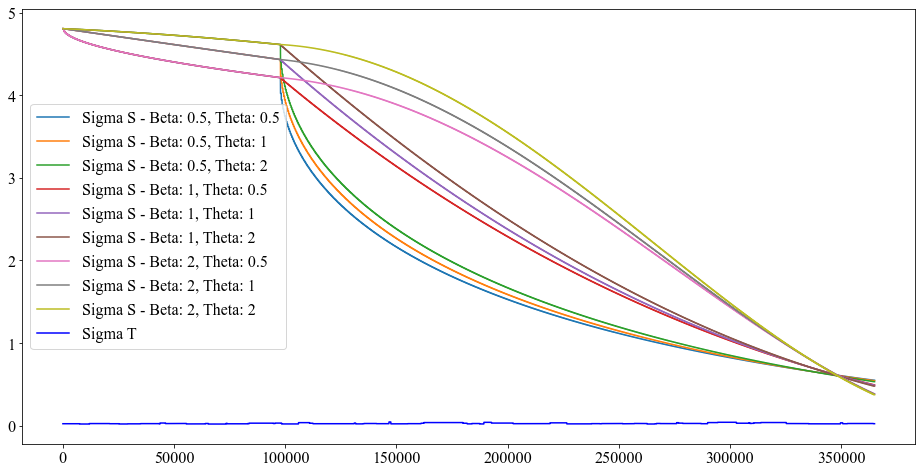

In [129]:
betaList = [0.5, 1, 2]
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    for theta in thetaList:
        params_column["beta"] = beta
        params_column["theta"] = theta
        circular_column = Column(**params_column)
        # Crack Depth
        lam = circular_column.calculateLambda()
        deltaT_day = circular_column.calculateDeltaT_day(duration_year=1000)
        # Strength Degradation
        a = circular_column.calculateA()
        R_day = circular_column.calculateR_day(duration_year=1000)
        sigmaS_day = circular_column.calculateSigmaS_day(duration_year=1000)
        label = "Sigma S - Beta: " + str(beta) + ", Theta: " + str(theta)
        plt.plot(sigmaS_day, label=label)
        
deadLoadSingle = circular_column.calculateDeadLoadSingle()
sustainedLiveLoad_day = circular_column.calculateSustainedLiveLoad_day(duration_year=1000)
sigmaT_day = circular_column.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_day)
plt.plot(sigmaT_day, color='b', label="Sigma T")
plt.legend(loc="best")
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 8 - Alpha

Text(0, 0.5, '')

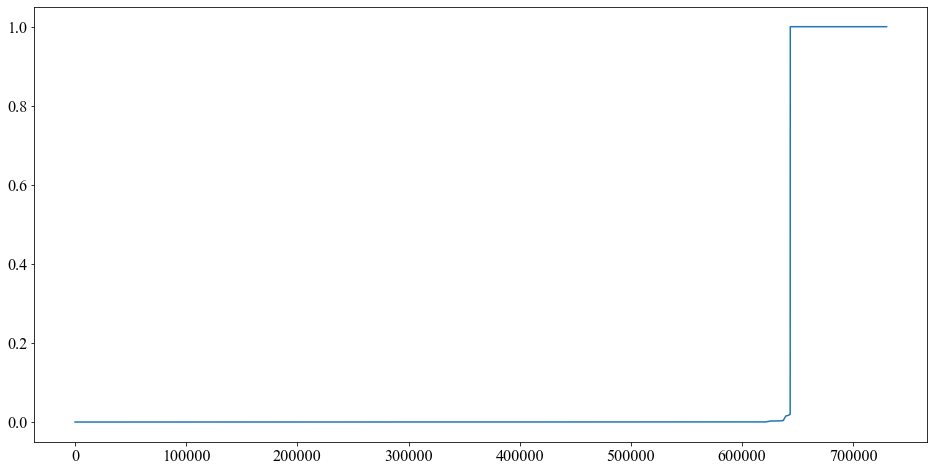

In [143]:
params_column["beta"] = 0.5
params_column["theta"] = 0.5
circular_column = Column(**params_column)
# Crack Depth
lam = circular_column.calculateLambda()
deltaT_day = circular_column.calculateDeltaT_day(duration_year=2000)
# Strength Degradation
a = circular_column.calculateA()
R_day = circular_column.calculateR_day(duration_year=2000)
sigmaS_day = circular_column.calculateSigmaS_day(duration_year=2000)

deadLoadSingle = circular_column.calculateDeadLoadSingle()
sustainedLiveLoad_day = circular_column.calculateSustainedLiveLoad_day(duration_year=2000)
sigmaT_day = circular_column.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_day)

# AlphaRate and Alpha
alphaRate, Alpha = circular_column.calculateAlpha(sigmaT=sigmaT_day, sigmaS=sigmaS_day)

# Find Index When Alpha Bigger Than 1
for index in range(len(Alpha)):
    if Alpha[index] > 1.0:
        alphaIndex = index
        break
Alpha[alphaIndex:] = 1

fig = plt.figure(figsize=(16, 8))
plt.plot(Alpha)
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 9 - Simulation for Alpha - Beta: 0.5, ThetaL 0.5

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 1820.04


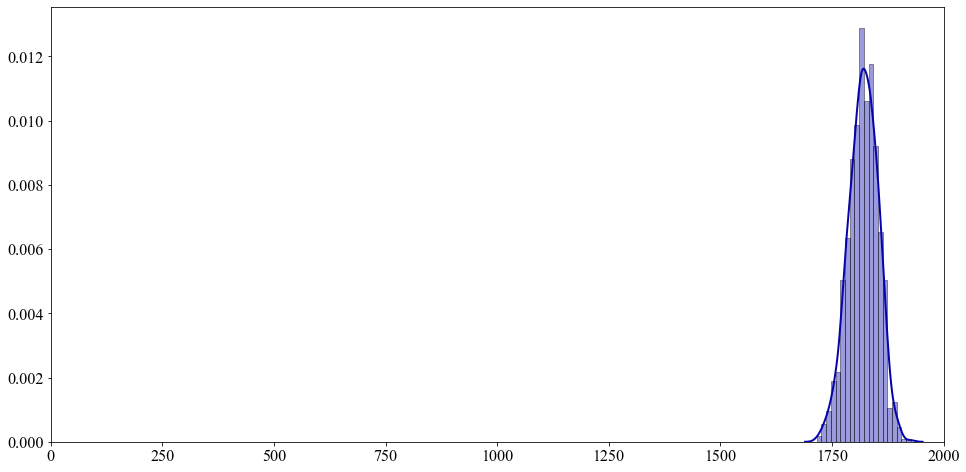

In [148]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))

for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
    params_column["beta"] = 0.5
    params_column["theta"] = 0.5
    circular_column1 = Column(**params_column)
    deadLoadSingle = circular_column1.calculateDeadLoadSingle()
    sustainedLiveLoad_year = circular_column1.calculateSustainedLiveLoad_year(duration_year=2000)
    sigmaT_year = circular_column1.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)
    
    circular_column = Column(**params_column)
    # Crack Depth
    lam = circular_column.calculateLambda()
    deltaT_year = circular_column.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = circular_column.calculateA()
    R_year = circular_column.calculateR_year(duration_year=2000)
    sigmaS_year = circular_column.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = circular_column.calculateAlpha(sigmaT=sigmaT_year, sigmaS=sigmaS_year)
    
    # Find Index When Alpha Bigger Than 1
    for index in range(len(Alpha)):
        if Alpha[index] > 1.0:
            alphaIndex = index
            break
    alphaIndexAll.append(alphaIndex)
    averageAlphaIndex = np.mean(alphaIndexAll)
    
# Plot Distribution
# plt.hist(alphaIndexAll, bins=100, color="#0504aa", alpha=0.7, rwidth=0.85, density=True)
# alphaIndexAllNonZero = list(filter(lambda num: num != 0, alphaIndexAll))
sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(20), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

